In [2]:
from utils import *
sda = spatialHM()
sda.check_torch_gpu()

-------------------------------------------------
------------------ VERSION INFO -----------------
Conda Environment: torchy | Python version: 3.8.16 (default, Mar  2 2023, 03:18:16) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1
Torch build with CUDA? True
# Device(s) available: 1, Name(s): Quadro P520



In [5]:
perm_true, perm_ens = sda.load_perms()
sat_true = np.load('sat_true.npy')

True Perm: (51, 51) | Perm Ensemble: (100, 51, 51)


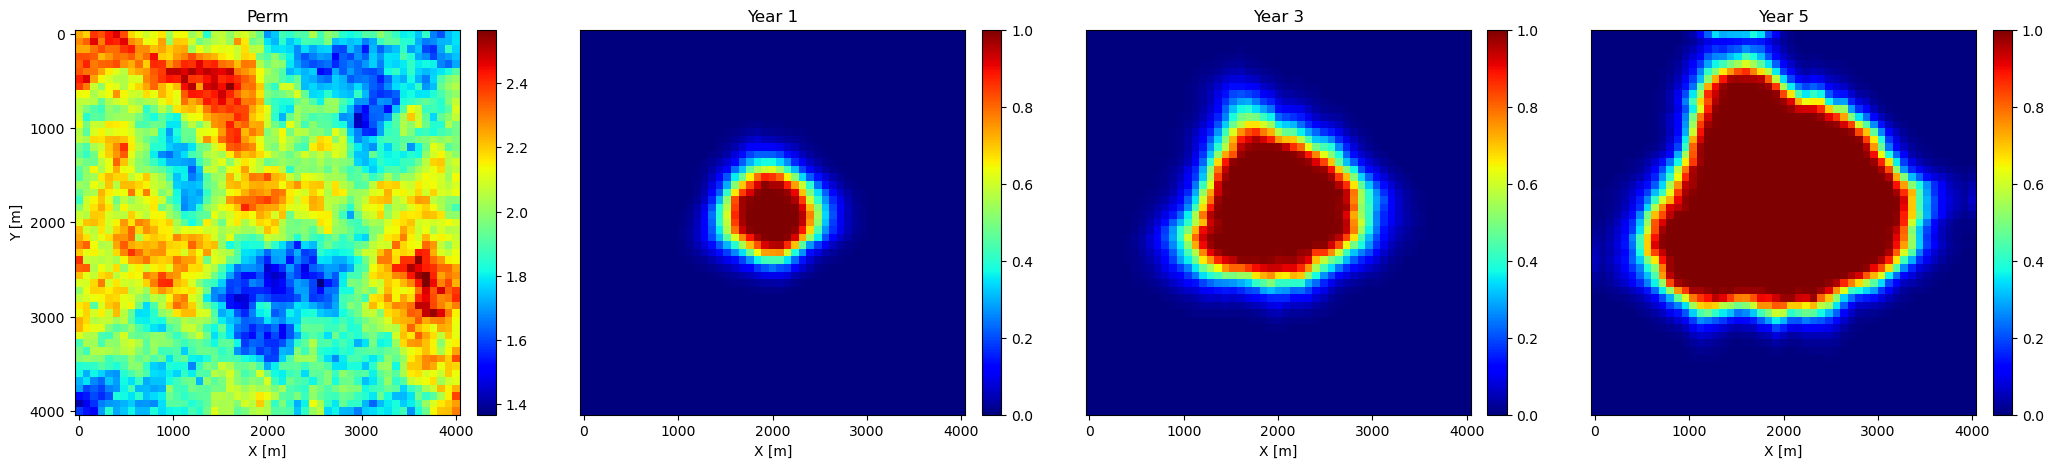

In [6]:
sda.plot_perm_sat(perm_true, sat_true)

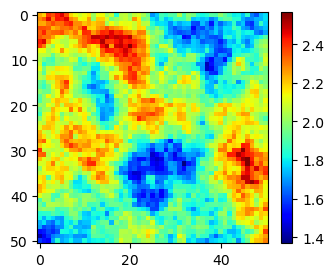

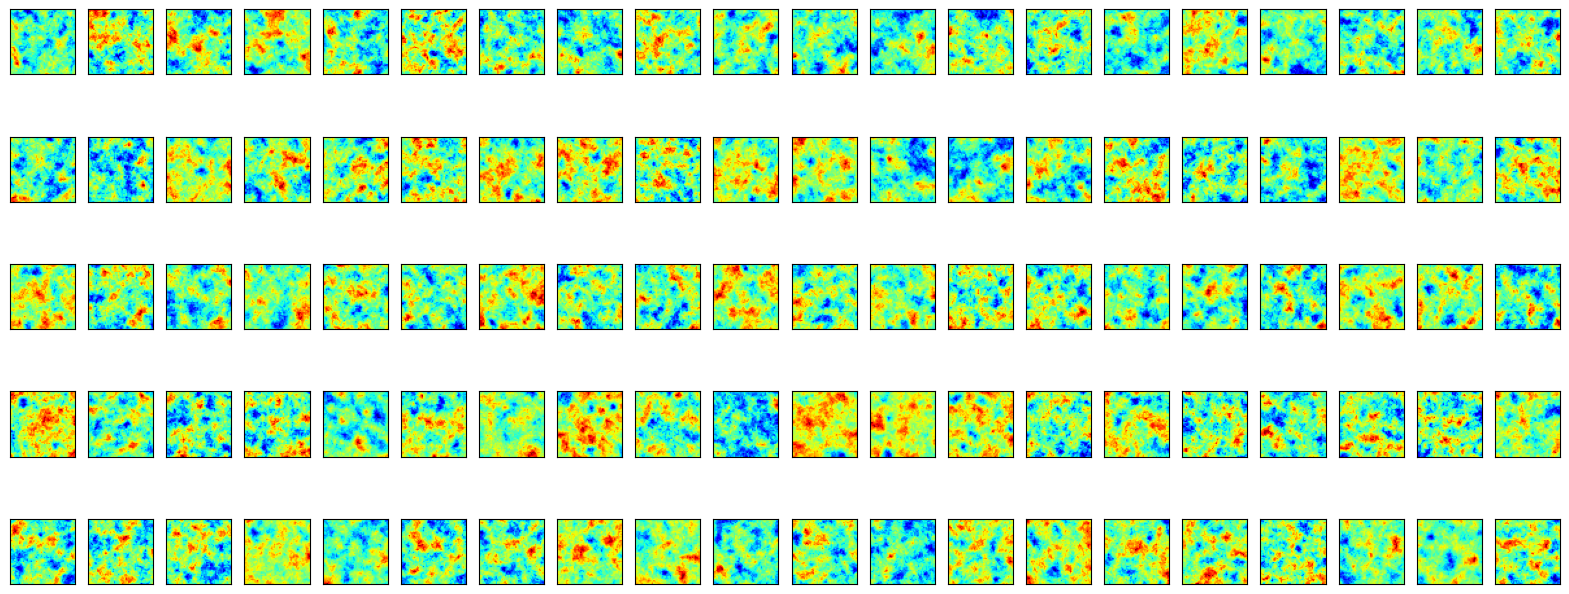

In [7]:
plt.figure(figsize=(4,3))
plt.imshow(perm_true, 'jet')
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

plt.figure(figsize=(20,8))
for i in range(100):
    plt.subplot(5,20,i+1)
    plt.imshow(perm_ens[i], 'jet')
    plt.xticks([]); plt.yticks([])
plt.show()

Assimilation # 1
Assimilation # 2
Assimilation # 3
a=9.98724 +/- 0.15138
b=-0.00197 +/- 0.00009


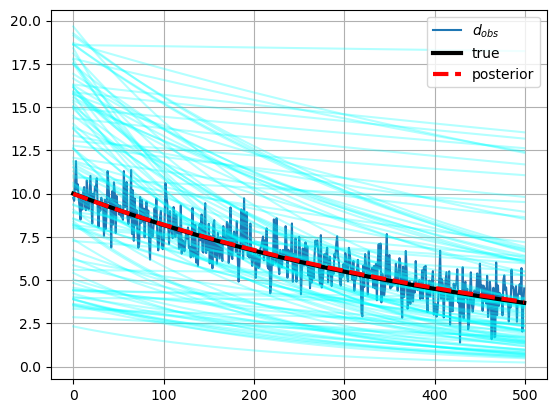

In [78]:
def exponential(p, x):
    return p[0] * np.exp(x * p[1])

def forward_model(m_ensemble, x):
    d_pred = np.zeros([m_ensemble.shape[0], x.shape[0]])
    for j in range(m_ensemble.shape[0]):
        d_pred[j,:] = exponential(m_ensemble[j,:], x)
    return d_pred

a = 10
b = -0.0020

# Observations
x = np.arange(500) #timesteps
obs = exponential((a,b), x) + np.random.normal(0, 1, x.shape[0])
cov_obs = np.diag([1]*obs.shape[0])

# Ensemble of parameters
n_ensemble = 100
ma = np.random.uniform(2, 20, size=n_ensemble)
mb = np.random.uniform(-0.005, 0, size=n_ensemble)
m_ensemble = np.stack((ma,mb), axis=1)
m_bounds = np.array([[0,50],[-1,1]])

n_assimilations = 3

cov_obs_inflation_geo = 1.2
cov_obs_inflation_factors = [1.1]
for l in range(1, n_assimilations):
    cov_obs_inflation_factors.append(cov_obs_inflation_factors[l - 1] / cov_obs_inflation_geo)
scaling_factor = np.sum(1 / np.array(cov_obs_inflation_factors))
cov_obs_inflation_factors = [alpha * scaling_factor for alpha in cov_obs_inflation_factors]

cov_mm_inflation_factors = [1.2] * n_assimilations

solver = ESMDA(obs, m_ensemble, cov_obs, forward_model, 
               forward_model_args        = (x,),
               forward_model_kwargs      = {},
               n_assimilations           = n_assimilations,
               cov_obs_inflation_factors = cov_obs_inflation_factors,
               cov_mm_inflation_factors  = cov_mm_inflation_factors,
               m_bounds                  = m_bounds,
               save_ensembles_history    = True)
solver.solve()


#approxtimate parameters
a_approx, b_approx = np.average(solver.m_prior, axis=0)
a_std, b_std = np.sqrt(np.diagonal(solver.cov_mm))

print('a={:.5f} +/- {:.5f}'.format(a_approx, a_std))
print('b={:.5f} +/- {:.5f}'.format(b_approx, b_std))

d = {}
for i in range(100):
    d[i] = exponential([m_ensemble[i,0], m_ensemble[i,1]], x)
    
plt.plot(x, obs, label='$d_{obs}$')
for i in range(100):
    plt.plot(x, d[i], alpha=0.3, c='cyan')
plt.plot(x, exponential([a,b], x), c='k', linewidth=3, linestyle='-', label='true')
plt.plot(x, exponential([a_approx,b_approx], x), c='r', linewidth=3, linestyle='--', label='posterior')
plt.legend(); plt.grid('on')
plt.show()

***
# END